<a href="https://colab.research.google.com/github/isongjosiah/identicrop/blob/main/True_gaze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curbing crop loss in Nigeria's Agricultural Ecosystem


---



---






About 690 million people are hungry today and three billion cannot afford a healthy diet [[1]](https://guardian.ng/apo-press-releases/food-loss-and-waste-must-be-reduced-for-greater-food-security-and-environmental-sustainability/) yet food continues to be wasted and lost. The status of global food security is alarming, and protection against losses caused by crop pests, plant diseases, in particular, can play a critical role in improving food security worldwide and meeting the growing demand for food quality and quantity. 

In this project, we process diseased and healthy apple crop images and build machine learning models that can help in the classification of diseased and healthy apple crops with plans to extend this implementation to all the crops in the Nigerian agricultural ecosystem.

#### Data and Goals
We made use of the [PlantVillage dataset](https://www.kaggle.com/abdallahalidev/plantvillage-dataset)  dataset which at the time of this project contained 54,343 colored images of diseased and healthy images of the following crops:


*   Apple
*   Corn
*   Grape
*   Orange
*   Peach
*   Pepper
*   Potato
*   Raspberry
*   Soybean
*   Squash
*   Strawberry
*   Tomato

However, for this project we trained our models on Apple crops only due to computation contraint.

#### Table of Content


*   [Data Exploration](#data-exploration)
*   [Data Preparation](#data-preparation)
*   [Train Validation Test Split](#train-validation-test-split)
*   [Data Augmentation](#data-augmentation)
*   [Feature Extraction](#feature-extraction)
*   [Supervised Learning](#supervised-learning)
*   [Results](#results)
*   [Exploration for future works](#exploration-for-future-works)
*   [Conclusions](#conclusions)
*   [Acknowledgements](#acknowledgements)
*   [References](#references)




In [ ]:
# utilities
from skimage import util
import joblib
import os
import random

# data preprocessing and machine learning
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from skimage.transform import resize, rotate
from skimage import exposure
from skimage.feature import hog
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
from scipy import ndimage
from skimage import io as skio
from skimage import filters
from scipy import misc

 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Global variables and utilities

# Variables
base_path = '/content/drive/MyDrive/dataset'
filenames = sorted(os.listdir(base_path))


# utilities
def make_folder(path):
  """ Check if a folder exists, if it doesn't exist create one in the given path
  Args:
    path [str]: path where the folder needs to be crerated
  """

  if not os.path.exists(os.path.join(path)):
    print(f'[INFO] Creating new folder {path}...')
    os.makedirs(os.path.join(path))



<a name="data-preparation"></a>
## 1 Data Preparation


### 1.1 Data Preprocessing


In [ ]:
'''
Gray images are resized to be of equal size and proportion, so as to reduce computation time.

'''
def remove_background(image_rgb):
  height, width = image_rgb.shape[:2]

  rectangle = (10,10,width-30,height-30)
  # Create initial mask
  mask = np.zeros(image_rgb.shape[:2], np.uint8)

  # Create temporary arrays used by grabCut
  bgdModel = np.zeros((1, 65), np.float64)
  fgdModel = np.zeros((1, 65), np.float64)

  # Run grabCut
  cv2.grabCut(image_rgb, # Our image
              mask, # The Mask
              rectangle, # Our rectangle
              bgdModel, # Temporary array for background
              fgdModel, # Temporary array for background
              5, # Number of iterations
              cv2.GC_INIT_WITH_RECT) # Initiative using our rectangle

  # Create mask where sure and likely backgrounds set to 0, otherwise 1
  mask_2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')

  # Multiply image with new mask to subtract background
  image_rgb_nobg = image_rgb * mask_2[:, :, np.newaxis]

  return image_rgb_nobg

In [ ]:
# Image processing code
def resize_image(image):
  """
  Resizes the image to a 100 by 100.
  Args:
    image (numpy array): Array of image pixels.

  Returns:
    (numpy array): Resized image
  """
  image = resize(image, (100,100))
  return image

In [ ]:
def threshold(image, value):
  image = image > value
  return image

def get_threshold_image(image):

  #converts image np array to grey scale
  r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  i = np.dot(image[...,:3], [0.299, 0.587, 0.114])

  im_th = threshold(i, 0.2)
  
  new_image = util.img_as_ubyte(im_th, force_copy=False)

  filled_image = ndimage.binary_fill_holes(new_image)
  
  return new_image


In [ ]:
def process_images(image):
  # image_bgr = cv2.imread(image_path)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_no_bgr = remove_background(image_rgb)
  resized_image = resize_image(image_no_bgr)
  image_thresh = get_threshold_image(resized_image)

  return image_thresh

### 1.2 Load images and labels

In order to use the images in training the machine learning model we had to load and label the images. As these images were not labelled from source we had to devise how to link a label to a particular image. Two arrays were created; One to hold the images and the other to hold the label of these images. 
The images stored into the array undergo preprocessing before they are stored in the array, so that images in the array are ready for subsequent steps of the pipeline.

so when an image is loaded, the label is also loaded. This ensures that the label of image[i] is present at label[i] making it easier to work with the models.

In [ ]:
def get_image_path(path, foldername=""):
    """
    The function reads images from a location, specified by the path returning an array containing the images in that
    location
    :param path: the location of the data.
    :param foldername: this by default is an empty string but can be used if the path contains multiple folders you
    you can then parse using a for loop and changing the value of the parameter at every iteration
    :return: an array of images in the path/filename directory
    """
    images = sorted([os.path.join(path, foldername, file) for file in os.listdir(os.path.join(path, foldername))])
    return images


def get_label(file_name):
  label = file_name.replace("___", " ")
  label = label.replace("_", " ")
  return label


def load_dataset(path, filenames):
    """
    load_dataset loads all of the images in the plantvillage dataset storing them in a dictionary with keys representing
    the foldernames and the values are arrays containing the images in the folder
    :param path: the location of the data
    :param filenames: a list of the folders in the path. This can be obtained by running sorted(os.listdir(path))
    :return: a dictionary with keys identifying the crops and diseased state(healthy or the type of diseases)and values
    which are arrays containing the images in that folder
    """
    images = []
    labels = []
    for i in filenames:
        # Ignore ipynb checkpoints and any other plant except apple
        if i == '.ipynb_checkpoints' or "Apple" not in i :
          continue
        img_arr = get_image_path(path, i)
        for img in img_arr:
          img = plt.imread(img)
          img = process_images(img)
          images.append(img)
          labels.append(get_label(i))
    img_arr = np.array(images)
    label_arr = np.array(labels)
          
    return images,labels

<a name="feature-extraction"></a>
## 2 Feature Extraction


For extracting features from the images, we made use of the [hog function](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html) present in the skimage feature module.

[Histogram of oriented gradients(HOG) ](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients) is a feature descriptor that is often used to extract features from image data widely used in computer vision tasks for object detection. The HOG feature descriptor counts the occurrences of gradient orientation in localized portions of an image.

The extract feature function takes loops through all of the train, test and validation datasets extracting the features from them and stores these extracted features for future use.



In [ ]:
def hog_feature(image):
  """
  Extract HOG feature descriptors from the image

  Args: 
    image (numpy array): Array of image pixels.

  Returns:
    (numpy array): Feature descriptors
  """
  return hog(image)

def extract_feature():
  """
  Load images and extract HOG feature desscriptors.
  """
  X_train = np.load(os.path.join(base_path, "augment/imageaugment_input.npy"))
  print("===TRAIN DATA===")
  print(len(X_train))
  print(X_train.shape)

  X_test = np.load(os.path.join(base_path, "test/imagetest_input.npy"))
  print("===TEST DATA===")
  print(len(X_test))
  print(X_test.shape)

  print("Extracting HOG features...")
  RF_train = np.zeros([len(X_train), 8100])
  for i in range(len(X_train)):
    RF_train[i] = hog_feature(X_train[i])
  print("FEATURE DESCRIPTORS")
  print(len(RF_train))

  RF_test = np.zeros([len(X_test), 8100])
  for i in range(len(X_test)):
    RF_test[i] = hog_feature(X_test[i])
  print(len(RF_test))

  # Save data
  make_folder(os.path.join(base_path, "processed"))
  np.save(os.path.join(base_path, "processed/imagetrainHOG_input.npy"), RF_train)
  np.save(os.path.join(base_path, "processed/imagetestHOG_input.npy"), RF_test)



<a name="data-augmentation"></a>
## 3 Data Augmentation

Data Augmentation is generally carried out in order to increase the amount of data by adding slightly modified copies of already existing data or newly synthetic data from existing data. This process also acts as a regularizer and helps reduce overfitting when training models.

For our project, we augmented the training data by performing geometric transformations on each sample. These includes: 



*   rotating the image at a random angle
*   flipping the image horizontally
*   flipping the image vertically
*   gama correction
*   intensity correction

These transformation especially the rotations and flipping of the images also serve to provide a wide range of images type as images upload to the deployed images might be rotated or flipped allowing the model to become used to those kind of data.



In [ ]:
# Data Augmentation
def random_rotation(img):
  """
  Randomly rotate the image.
  The function picks a random degree of rotation between 25% on the 
  left and 25% on the right

  Args:
    img (numpy array): Array of image pixel to rotate

  Returns:
    (numpy array): Rotated image.
  """
  random_deg = random.uniform(-25, 25)
  return rotate(img, random_deg, preserve_range=True).astype(np.uint8)

def horizontal_flip(img):
  """
  Flip the image horizontally
  Args:
    img (numpy array): Array of image pixels.

  Returns:
    (numpy array): Flipped image.
  """
  return np.fliplr(img)

def vertical_flip(img):
  """
  Flip the image vertically
  Args:
    img (numpy array): Array of image pixels
  Returns:
    (numpy array): Flipped image.
  """
  return np.flipud(img)

def gama(img):
  """
  Perform gamma correction of the image

  Args:
    img (numpy arrayy): Array of image pixes

  Returns:
    (numpy array): Enhanced image.
  """
  return exposure.adjust_gamma(img, gamma=0.4, gain=0.9)


def intensity(img):
    """ 
    Change the intensity of the image.
    Args:
        img (numpy array): Array of image pixels.
    Returns:
        (numpy array): Enhanced image.
    """
    v_min, v_max = np.percentile(img, (0.2, 99.8))
    if np.abs(v_max - v_min) < 1e-3:
        v_max += 1e-3
    return exposure.rescale_intensity(img, in_range=(v_min, v_max))

def augment_image(img, label):
  """
  Performs image augmentation using rotation, intensity scaling,
  flip and gamma correction.
  Args:
    img (numpy array): array of image pixels.
    label (str): Label of the image.
  Returns:
    (numpy array): Augmented images.
    (numpy array): Array of labels corresponding to the images.
  """
  temp = [horizontal_flip(img), vertical_flip(img), random_rotation(img), gama(img), intensity(img)]
  label = [label, label, label, label, label]
  return temp, label


def augment_data():
  """
  Load the train data and augment loaded data.
  """
  X_train = np.load(os.path.join(base_path, "intermediate/imagetrain_input.npy"))
  y_train = np.load(os.path.join(base_path, "intermediate/labeltrain_input.npy"))
  print("DATA TO BE AUGMENTED")
  print(len(X_train))
  print(len(y_train))

  as_count = br_count = ar_count = 0
  transformed_image = []
  labels = []

  for i, name in enumerate(y_train):
    if name == 'Apple healthy':
      x, y = augment_image(X_train[i], name)
      transformed_image.extend(x)
      labels.extend(y)
    elif name == 'Apple Apple scab':
      x, y = augment_image(X_train[i], name)
      transformed_image.extend(x)
      labels.extend(y)
      as_count += 1
    elif name == 'Apple Black rot':
      x, y = augment_image(X_train[i], name)
      transformed_image.extend(x)
      labels.extend(y)
      br_count += 1    
    elif name == 'Apple Cedar apple rust':
      x, y = augment_image(X_train[i], name)
      transformed_image.extend(x)
      labels.extend(y)
      ar_count += 1

  transformed_image = np.array(transformed_image)
  labels = np.array(labels)
  print("AUGMENTED DATA")
  print(len(transformed_image))
  print(len(labels))

  # Concatenate with initial image array
  X_train = np.concatenate((X_train, transformed_image), axis=0)
  y_train = np.concatenate((y_train, labels), axis=0)
  print("TOTAL MODEL INPUT DATA")
  print(len(X_train))
  print(len(y_train))

  # Save data
  make_folder(os.path.join(base_path, "augment"))
  np.save(os.path.join(base_path, "augment/imageaugment_input.npy"), X_train)
  np.save(os.path.join(base_path, "augment/labelaugment_input.npy"), y_train)


<a name="supervised-learning"></a>
## 4 Supervised Learning


### 4.1 Classification Algorithm

In [ ]:
# SVM model
def run_svm():
  """
  Load the data. Train SVM model using linear kernel. Print accuracy on test dat.
  """
  X_train = np.load(os.path.join(base_path, "processed/imagetrainHOG_input.npy"))
  y_train = np.load(os.path.join(base_path, "augment/labelaugment_input.npy"))

  print("=== TRAIN DATA ===")
  print(len(X_train))
  print(len(y_train))

  X_test = np.load(os.path.join(base_path, "processed/imagetestHOG_input.npy"))
  y_test = np.load(os.path.join(base_path, "test/labelstest_input.npy"))

  print("=== TEST DATA ===")
  print(len(X_test))
  print(len(y_test))

  svm_model = LinearSVC(dual=False)
  svm_model.fit(X_train, y_train)


  print(f"SVM accuracy score {svm_model.score(X_test, y_test)}")
   
  make_folder(os.path.join(base_path, "results/models"))
  joblib.dump(svm_model, os.path.join(base_path, "results/models/SVM_MODEL.sav"))


In [ ]:
# Random Forest model
def run_random_forest():
  """
  Load the data. Train the model and print out the accuracy on test data
  """

  X_train = np.load(os.path.join(base_path, "processed/imagetrainHOG_input.npy"))
  y_train = np.load(os.path.join(base_path, "augment/labelaugment_input.npy"))
  print("=== TRAIN DATA ===")
  print(len(X_train))
  print(len(y_train))

  X_test = np.load(os.path.join(base_path, "processed/imagetestHOG_input.npy"))
  y_test = np.load(os.path.join(base_path, "test/labelstest_input.npy"))

  print("=== TEST DATA ===")
  print(len(X_test))
  print(len(y_test))

  # Classifier
  Random_classifier = RandomForestClassifier(n_estimators=500, max_depth=35,
                                               n_jobs=-1, warm_start=True,
                                               oob_score=True,
                                               max_features='sqrt')
  Random_classifier.fit(X_train, y_train)
  print(f"Random Forest accuracy score {Random_classifier.score(X_test, y_test)}")

  make_folder(os.path.join(base_path, "results/models"))
  joblib.dump(Random_classifier, os.path.join(base_path, "results/models/RANDOM_FOREST_MODEL.sav"))



In [ ]:
# KNeighbors classifier
def run_kneighbors():
  """
  Load the data. Train the model and print out the accuracy on test data
  """

  X_train = np.load(os.path.join(base_path, "processed/imagetrainHOG_input.npy"))
  y_train = np.load(os.path.join(base_path, "augment/labelaugment_input.npy"))
  print("=== TRAIN DATA ===")
  print(len(X_train))
  print(len(y_train))

  X_test = np.load(os.path.join(base_path, "processed/imagetestHOG_input.npy"))
  y_test = np.load(os.path.join(base_path, "test/labelstest_input.npy"))

  print("=== TEST DATA ===")
  print(len(X_test))
  print(len(y_test))

  # Classifier
  clf = KNeighborsClassifier(n_neighbors=3)

  clf.fit(X_train, y_train)
  print(f"K Neighbors accuracy score {clf.score(X_test, y_test)}")

  make_folder(os.path.join(base_path, "results/models"))
  joblib.dump(clf, os.path.join(base_path, "results/models/KNeighbors.sav"))

### 4.2 Prediction

In [ ]:
# Predict single image
def predict(img):
  """
  Predict the classification of a single image
  Args:
    img(numpy array)
  Returns:
    (string) label for images
  """
  # take the image through preprocessing
  img = plt.imread(img)
  img = process_images(img)
  img = np.array(img)
  img = hog_feature(img)
  
  img = img.reshape(1, -1)

  # load the models
  svm_model = joblib.load(os.path.join(base_path, "results/models/SVM_MODEL.sav"))
  rfc_model = joblib.load(os.path.join(base_path, "results/models/RANDOM_FOREST_MODEL.sav"))
  knn_model = joblib.load(os.path.join(base_path, "results/models/KNeighbors.sav"))

  # Predict
  svm_label = svm_model.predict(img)
  rfc_label = rfc_model.predict(img)
  knn_label = knn_model.predict(img)

  print(f"SVM Classifier predicts {svm_label}")
  print(f"Random Forest Classifier predicts {rfc_label}")
  print(f"KNN predicts {knn_label}")


In [ ]:
#Load the Images
images, labels = load_dataset(base_path, filenames)
print('=== TOTAL DATA ===')
print(len(labels))
print(len(images))


=== TOTAL DATA ===
2336
2336


<a name="train-validation-test-split"></a>
## 5 Train Validation Test Split

In [ ]:
# Shuffle data
images, labels = shuffle(images, labels, random_state=42)
print(np.unique(labels))

# Split train set and test set
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state= 42)

print('=== TRAIN TEST SPLIT ===')
print(len(X_train))
print(len(X_test))

['Apple Apple scab' 'Apple Black rot' 'Apple Cedar apple rust'
 'Apple healthy']
=== TRAIN TEST SPLIT ===
1868
468


In [ ]:
# Save data
base_path = '/content/drive/MyDrive/dataset'
make_folder(os.path.join(base_path, "test"))
make_folder(os.path.join(base_path, "intermediate"))
np.save(os.path.join(base_path, "test/imagetest_input.npy"), X_test)
np.save(os.path.join(base_path, "test/labelstest_input.npy"), y_test)
np.save(os.path.join(base_path, "intermediate/imagetrain_input.npy"), X_train)
np.save(os.path.join(base_path, "intermediate/labeltrain_input.npy"), y_train)


<a name="results"></a>
## 6 Results

### 6.1 Baseline performance

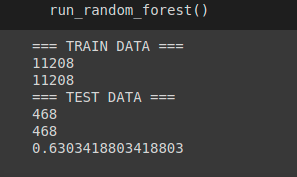

In [ ]:
augment_data()
extract_feature()
run_svm()
run_random_forest()
run_kneighbors()

DATA TO BE AUGMENTED
1868
1868
AUGMENTED DATA
9340
9340
TOTAL MODEL INPUT DATA
11208
11208
===TRAIN DATA===
11208
(11208, 100, 100)
===TEST DATA===
468
(468, 100, 100)
Extracting HOG features...
FEATURE DESCRIPTORS
11208
468
=== TRAIN DATA ===
11208
11208
=== TEST DATA ===
468
468
SVM accuracy score 0.6175213675213675
=== TRAIN DATA ===
11208
11208
=== TEST DATA ===
468
468
Random Forest accuracy score 0.7200854700854701
=== TRAIN DATA ===
11208
11208
=== TEST DATA ===
468
468
K Neighbors accuracy score 0.6111111111111112


In [ ]:
predict("/content/drive/MyDrive/dataset/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG")

SVM Classifier predicts ['Apple Apple scab']
Random Forest Classifier predicts ['Apple Apple scab']
KNN predicts ['Apple Apple scab']


<a name="exploration-for-future-works"></a>
## 7 Exploration for future works


<a name="conclusions"></a>
## 8 Conclusions


<a name="acknowledgements"></a>
## 9 Acknowledgements

<a name="references"></a>
## 10 References